In [40]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
from scipy.optimize import curve_fit

In [15]:
water = 0
empty = 1
wall = 2

@jit(nopython = True)
def point_move(m, n, lattice):
    L = len(lattice)
    points = [(m, n+1), (m, n-1), (m-1, n), (m+1, n)]
    for point in points:
        if point[0] > L-1 or point[0] < 0 or point[1] > L-1 or point[1] < 0:
            continue
        if lattice[point] == empty:
            lattice[point] = water
            # if point[1] == L-1:
            #     return
            point_move(point[0], point[1], lattice)

@jit(nopython=True)
def lattice(p, L):
    lattice = np.random.rand(L, L)
    lattice = np.where(lattice<=p, empty, wall)
    return lattice

@jit(nopython=True)
def percolate(lattice, results, n):
    lattice[0, :] = np.where(lattice[0, :] == empty, water, wall)
    for i in range(len(lattice)):
        if lattice[0, i]==water:
            point_move(0, i, lattice)
    if water in lattice[-1, :]:
        results[n] = 1
    return lattice


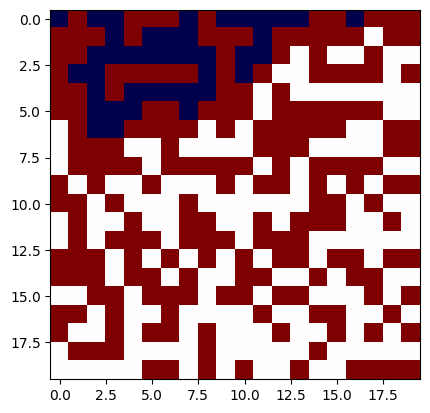

In [21]:
p = 0.5
L=20
l = np.array([0])

plt.imshow(percolate(lattice(p, L), l, 0), cmap = 'seismic')

In [37]:
Np = 20 # prób dla każdego P
P_num = 100

@jit(nopython=True)
def probability_L(L):
    P = np.linspace(0, 1, P_num)
    P_res = np.zeros(P_num)
    P_err = np.zeros(P_num)
    for n, p in enumerate(P):
        results = np.zeros(Np)
        for i in range(Np):
            l = lattice(p, L)
            l = percolate(l, results, i)
        P_res[n] = np.mean(results)
        P_err[n] = np.std(results)
    pcmin = np.max(P[P_res==0])
    pcmax = np.min(P[P_res==1])
    return P_res, P_err, pcmin, pcmax


In [ ]:
# P = np.linspace(0, 1, P_num)
# p1, p2, p3 = probability_L(110)
# plt.plot(P, p1)


In [38]:
Ls = np.array([40, 60, 80, 100, 120, 140, 160])

prob_results_min = np.array([])
prob_results_max = np.array([])


for size in Ls:
    p1, p2, pcmin, pcmax = probability_L(size)
    prob_results_min = np.append(prob_results_min, pcmin)
    prob_results_max = np.append(prob_results_max, pcmax)



In [55]:
def line(x, a, b):
  return a*x+b

parmin, cov = curve_fit(line, 1/Ls, prob_results_min)
parmax, cov = curve_fit(line, 1/Ls, prob_results_max)

bmin = parmin[1]
bmax = parmax[1]
pavg = 0.5*(bmin+bmax)

Text(0.025, 0.605, '$p_c = $0.5990')

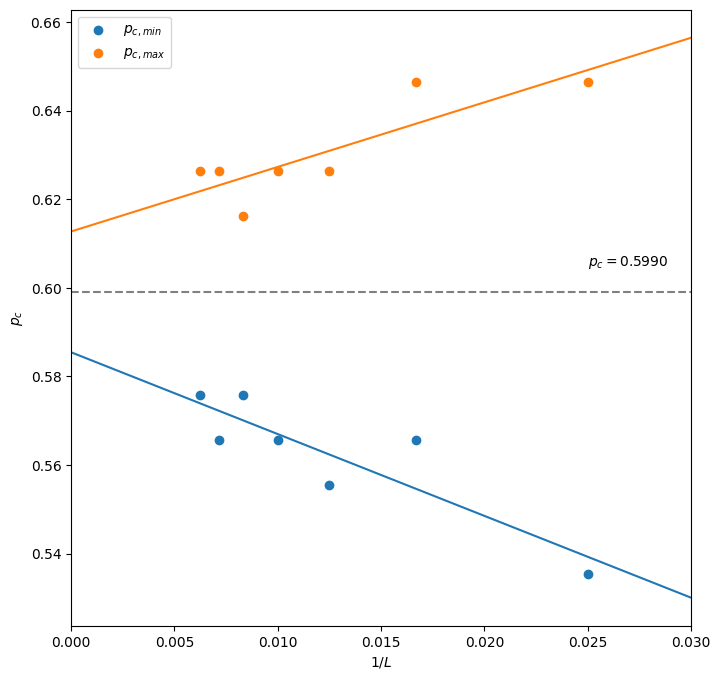

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))

x = np.array([0, 0.03])


ax.scatter(1/Ls, prob_results_min, label = "$p_{c, min}$")
ax.scatter(1/Ls, prob_results_max, label = "$p_{c, max}$")
ax.plot(x, line(x, parmin[0], bmin))
ax.plot(x, line(x, parmax[0], bmax))
ax.set_xlabel("$1/L$")
ax.set_xlim([0, 0.03])
ax.set_ylabel("$p_c$")
ax.plot(x, [pavg, pavg], '--', color='gray')
ax.legend()
plt.text(0.025, 0.605, "$p_c = $"+str(pavg)[:6])


